In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
import matplotlib.pyplot as plt
import io

In [ ]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

Saving JNJ.csv to JNJ.csv


In [ ]:
features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
features = np.nan_to_num(features)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [ ]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length, 3])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_features, sequence_length)
train_size = int(len(X) * 0.8)
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(50),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_split=0.1, verbose=1)


Epoch 1/50
176/176 [==============================] - 39s 150ms/step - loss: 0.3855 - val_loss: 0.0522
Epoch 2/50
176/176 [==============================] - 23s 132ms/step - loss: 0.1549 - val_loss: 0.0459
Epoch 3/50
176/176 [==============================] - 25s 140ms/step - loss: 0.0672 - val_loss: 0.0168
Epoch 4/50
176/176 [==============================] - 22s 124ms/step - loss: 0.0274 - val_loss: 9.9595e-04
Epoch 5/50
176/176 [==============================] - 23s 133ms/step - loss: 0.0110 - val_loss: 2.0484e-04
Epoch 6/50
176/176 [==============================] - 23s 133ms/step - loss: 0.0043 - val_loss: 1.5174e-04
Epoch 7/50
176/176 [==============================] - 22s 126ms/step - loss: 0.0018 - val_loss: 2.1554e-04
Epoch 8/50
176/176 [==============================] - 24s 136ms/step - loss: 9.5407e-04 - val_loss: 2.7004e-04
Epoch 9/50
176/176 [==============================] - 22s 128ms/step - loss: 6.5769e-04 - val_loss: 4.2859e-04
Epoch 10/50
176/176 [====================

In [ ]:
predicted_prices = model.predict(test_X)
predicted_prices_extended = np.zeros((predicted_prices.shape[0], scaled_features.shape[1]))
predicted_prices_extended[:, 3] = predicted_prices[:, 0]
predicted_prices = scaler.inverse_transform(predicted_prices_extended)[:, 3]

test_y_extended = np.zeros((test_y.shape[0], scaled_features.shape[1]))
test_y_extended[:, 3] = test_y
real_prices = scaler.inverse_transform(test_y_extended)[:, 3]

98/98 [==============================] - 5s 36ms/step


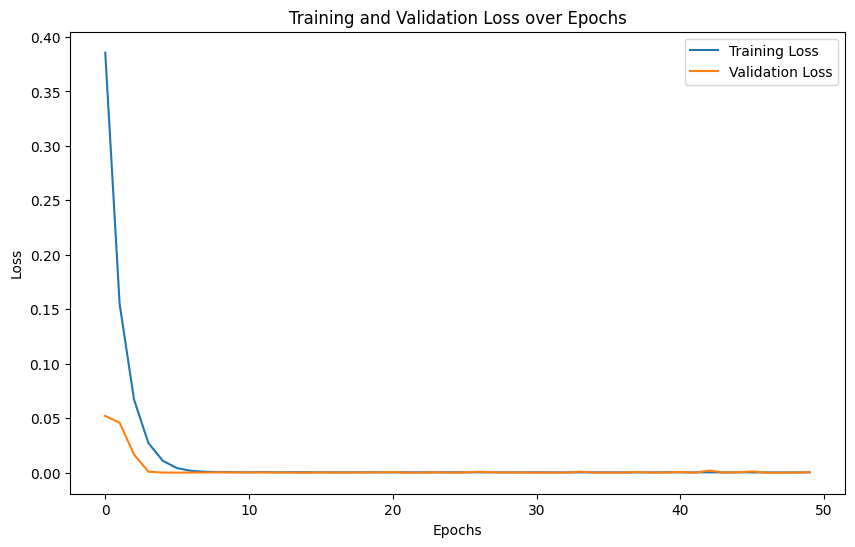

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

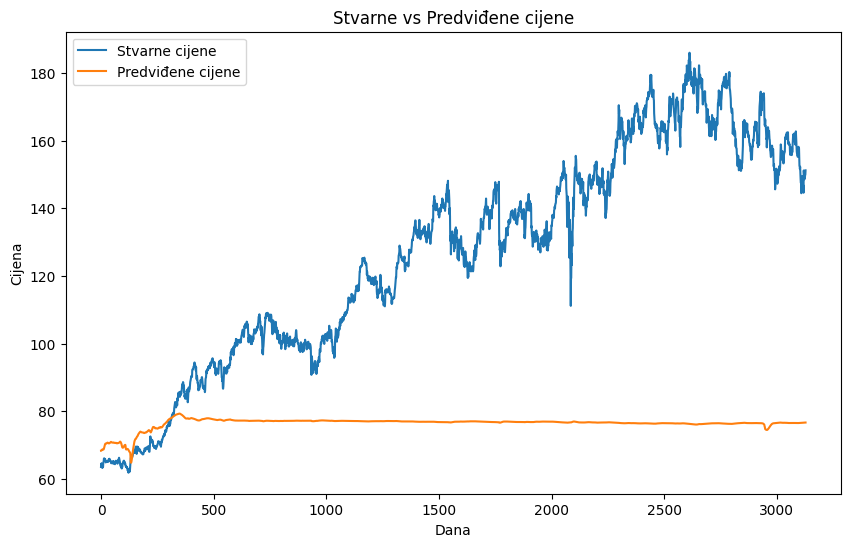

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(real_prices, label='Stvarne cijene')
plt.plot(predicted_prices, label='Predviđene cijene')
plt.title('Stvarne vs Predviđene cijene')
plt.xlabel('Dana')
plt.ylabel('Cijena')
plt.legend()
plt.show()